# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

Ideas:
- Parallelize the code.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [1]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial

In [2]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c

In [3]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    rolling_ols_window = 100
    exp_rolling_ols_lambda=0.02

In [8]:
# Helper functions
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
performance_record_mse = {}
performance_record_wacc = {}

def create_random_sensitivity(timespan):
    num_points = int(np.round(np.random.rand()*8) + 2)
    smoothing_parameter = np.exp(2*np.random.rand() - 1.5)
    x = np.floor(np.random.rand(num_points)*timespan)
    x = np.append(x, [0, timespan-1])
    x.sort()
    y = 2*np.random.rand(num_points + 2) - 1

    
    spleen = splrep(x, y, s=smoothing_parameter)
    t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
    values = splev(t, spleen)
    sensitivity = pd.Series(data=values, index=t)
    sensitivity[sensitivity < -5] = -5
    sensitivity[sensitivity > 5] = 5
    return sensitivity

def plot_estimated_sensitivities(sens, est_sens, colors):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    axc = ax[0,0]
    axc.plot(est_sens.iloc[:,0], c=colors[0])
    axc.plot(sens.iloc[:,0], '--', c='k')
    axc = ax[0,1]
    axc.plot(est_sens.iloc[:,1], c=colors[1])
    axc.plot(sens.iloc[:,1], '--', c='k')
    axc = ax[1,0]
    axc.plot(est_sens.iloc[:,2], c=colors[2])
    axc.plot(sens.iloc[:,2], '--', c='k')
    
def compute_estimated_returns(factors, est_sens):
    return pd.Series(np.multiply(factors, est_sens.shift()).sum(axis=1))

def plot_residuals(estimated_returns, returns):
    residuals = estimated_returns - returns
    plt.scatter(residuals.index, residuals, s=0.5)
    
def print_mse_performance(estimated_returns, returns, name, performance_record_mse, verbose=True):
    square_errors = np.square(estimated_returns - returns)
    mean_square_error = square_errors.sum()/len(estimated_returns)
    performance_record_mse[name] = mean_square_error
    if verbose:
        print(f"MSE for {name}, assuming the factors known: {mean_square_error}")
    
def print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc, verbose=True):
    weights = abs(returns)
    correct_sign = -2*np.logical_xor(estimated_returns > 0, returns > 0) + 1
    weighted_accuracy = np.multiply(weights, correct_sign).mean()
    performance_record_wacc[name] = weighted_accuracy
    if verbose:
        print(f"Weighted accuracy for {name}, assuming the factors known: {weighted_accuracy}")
    
def plot_prediction_performance(factors, returns, est_sens, name):
    estimated_returns = compute_estimated_returns(factors, est_sens)
    print_mse_performance(estimated_returns, returns, name, performance_record_mse)
    print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc)
    plot_residuals(estimated_returns, returns)
    

In [9]:
# Sensitivities
timespan = 10000

def get_sensitivities(timespan, sens_type):
    pi = 3.1415
    if sens_type == "Various smooth":
        t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
        sens1 = -(pd.Series(np.arctan((t-timespan/2)/timespan*100)) - pi/2)/pi
        sens2 = (pd.Series(np.sin(t/timespan*3.2 - 1.5)) + 1)/2
        sens3 = pd.Series(np.sin(t/timespan*5) + np.sin(t/timespan*10 + 150) + \
                          np.sin(t/timespan*20 + 150))/2
    elif sens_type == "Random walk":
        sens1 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 + 1
        sens2 = pd.Series(np.random.normal(size=timespan)).cumsum()/200
        sens3 = pd.Series(np.random.normal(size=timespan)).cumsum()/200 - 1
    elif sens_type == "Random smooth":
        sens1 = create_random_sensitivity(timespan)
        sens2 = create_random_sensitivity(timespan)
        sens3 = create_random_sensitivity(timespan)

    return pd.concat([sens1, sens2, sens3], axis=1)

sens = get_sensitivities(timespan, sens_type)

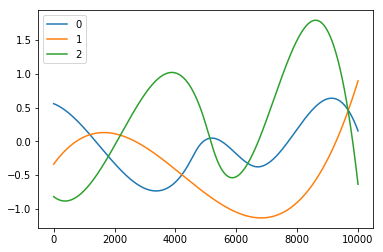

In [10]:
sens.plot()

In [11]:
# Factors
def get_factors(timespan):
    
    factor1 = pd.Series(np.random.normal(size=timespan))
    factor2 = pd.Series(np.random.normal(size=timespan))
    factor3 = pd.Series(np.random.normal(size=timespan))
    return pd.concat([factor1, factor2, factor3], axis=1)

factors = get_factors(timespan)

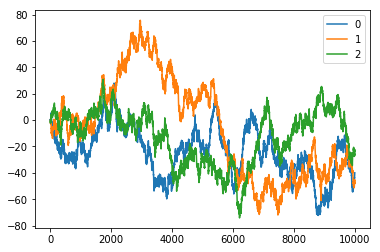

In [12]:
factors.cumsum(axis=0).plot()

In [13]:
# Returns
def get_returns(timespan, factors, sens, error_std):
    error = np.random.normal(size=timespan)*error_std
    return pd.Series(np.multiply(factors, sens).sum(axis=1) + error)

returns = get_returns(timespan, factors, sens, 1.0)

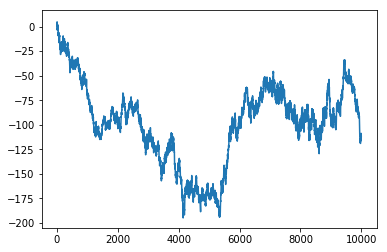

In [14]:
returns.cumsum().plot()

## Constant regression

In [15]:
def estimate_sensitivities_cr(factors, returns):
    reg = linear_model.LinearRegression()
    reg.fit(factors, returns)
    return pd.DataFrame(data = [reg.coef_], index = factors.index)

In [16]:
estimated_sensitivities_cr = estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,-0.057885,-0.421582,0.359114
1,-0.057885,-0.421582,0.359114
2,-0.057885,-0.421582,0.359114
3,-0.057885,-0.421582,0.359114
4,-0.057885,-0.421582,0.359114
5,-0.057885,-0.421582,0.359114
6,-0.057885,-0.421582,0.359114
7,-0.057885,-0.421582,0.359114
8,-0.057885,-0.421582,0.359114
9,-0.057885,-0.421582,0.359114


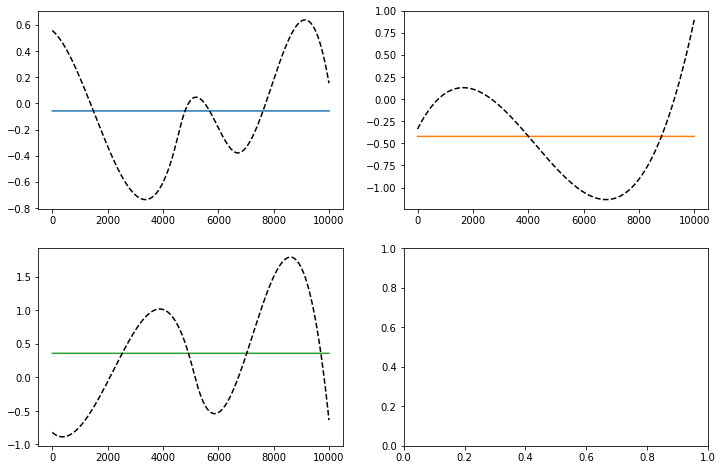

In [17]:
plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 2.07602344668911
Weighted accuracy for Constant OLS, assuming the factors known: 0.4296812458179007


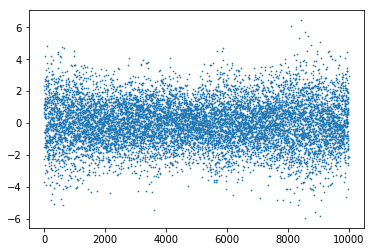

In [18]:
plot_prediction_performance(factors, 
                            returns, 
                            estimated_sensitivities_cr, 
                            "Constant OLS")

## Rolling regression

In [19]:
def estimate_sensitivities_rr(factors, returns, window):
    model = PandasRollingOLS(y=returns, x=factors, window=window)
    return pd.DataFrame(model.beta)

In [20]:
window = rolling_ols_window
estimated_sensitivities_rr = estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
99,0.616530,-0.372730,-0.852164
100,0.622812,-0.385958,-0.847334
101,0.634456,-0.380650,-0.807903
102,0.628794,-0.360358,-0.812486
103,0.631189,-0.359121,-0.817803
104,0.635227,-0.349302,-0.816132
105,0.633121,-0.349681,-0.815318
106,0.619511,-0.333437,-0.805808
107,0.622040,-0.308954,-0.813862
108,0.615789,-0.310578,-0.829857


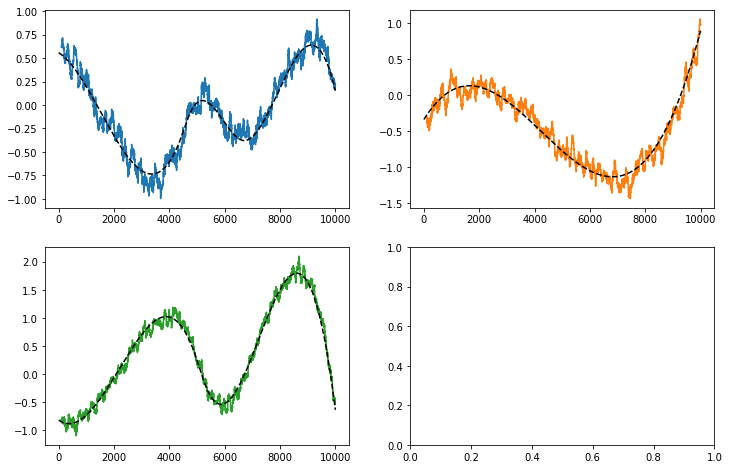

In [21]:
plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 1.0506461768931277
Weighted accuracy for Rolling OLS, assuming the factors known: 0.8636583697926323


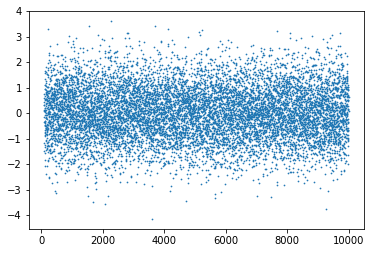

In [22]:
plot_prediction_performance(factors.iloc[window-1:,:], 
                            returns.iloc[window-1:], 
                            estimated_sensitivities_rr, 
                            "Rolling OLS")

## Weighted rolling regression

In [23]:
# How to do that efficiently??

In [24]:
def estimate_sensitivities_err(factors, returns, lambd):
    ff = np.zeros([3,3])
    fr = np.zeros(3)
    est_sens_list = []
    for i, row in factors.iterrows():
        ff = (1-lambd)*ff + lambd*np.outer(row, row)
        fr = (1-lambd)*fr + lambd*np.dot(row, returns.iloc[i])
        est_sens = np.dot(np.linalg.inv(ff + 1e-9*np.eye(3)), fr)
        est_sens_list.append(est_sens)
    return pd.DataFrame(est_sens_list)  

In [25]:
estimated_sensitivities_err = estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

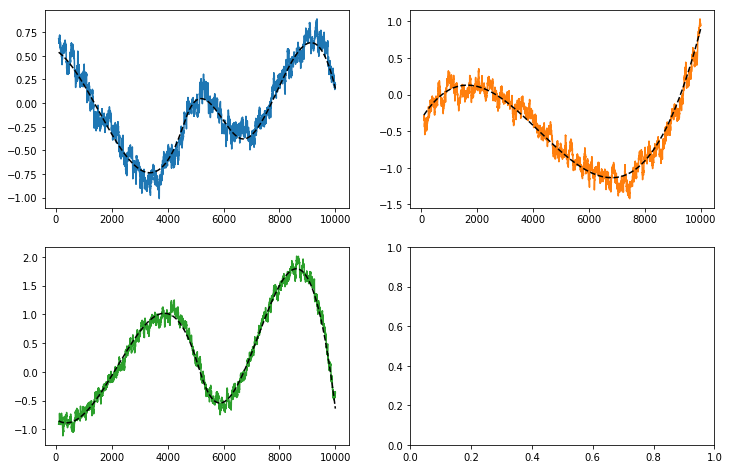

In [26]:
plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 1.0566082749756507
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 0.8623286343881007


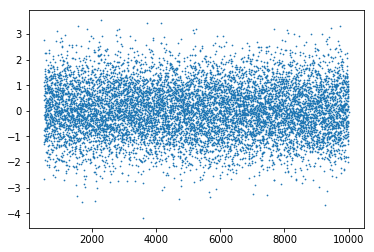

In [27]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_err.iloc[burn_period:,:], 
                            "Exponential rolling OLS")

## Kalman filter

In [28]:
def estimate_sensitivities_kf(factors, returns, covariance_ratio):
    n_dim_state=3
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = np.eye(3)*covariance_ratio
    observation_matrices = factors.values[:,np.newaxis,:]
    kf = KalmanFilter(initial_state_mean=[0,0,0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means)

In [29]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

NameError: name 'kalman_covariance_ratio' is not defined

In [ ]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

In [ ]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_kf.iloc[burn_period:,:], 
                            "Kalman")

In [ ]:
def estimate_sensitivities_ntc(estimated_sensitivities, trend_factor, window):
    rolling_mean = estimated_sensitivities.rolling(window, axis=0).mean()
    return (1 + trend_factor)*pd.DataFrame(estimated_sensitivities) - trend_factor*rolling_mean

In [ ]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc
#rolling_mean = pd.DataFrame(filtered_state_means).rolling(100, axis=0).mean()
#trend_est_sens = (1 + trend_factor)*pd.DataFrame(filtered_state_means) - trend_factor*rolling_mean

In [ ]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

In [ ]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], estimated_sensitivities_kf_ntc.iloc[burn_period:,:], "Kalman naive trend")

## Stochastic trend Kalman filter

In [ ]:
def estimate_sensitivities_stkf(factors, returns, covariance_ratio):
    n_dim_state=6
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = covariance_ratio*np.eye(6)
    observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                     factors.values[:, 1], 0*factors.values[:, 1],
                                     factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
    transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
    kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance,
                      transition_matrices=transition_matrix
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means[:,[0,2,4]])

In [ ]:
estimated_sensitivities_stkf = estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

In [ ]:
plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

In [ ]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_stkf.iloc[burn_period:,:], 
                            "Kalman stoch trend")

## Performance summary

In [ ]:
pd.Series(performance_record_mse).sort_values()

In [ ]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

## Optimisation of the hyperparameters

In [30]:
def estimate_regression_performance(factors, returns, name, performance_record_mse, 
                                    performance_record_wacc, **kwargs):
    burn_period = 500
    if name[:12] == "Constant OLS":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_cr(factors, returns)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:11] == "Rolling OLS":
        start_time = burn_period
        rolling_ols_window = kwargs['rolling_ols_window']
        estimated_sensitivities = estimate_sensitivities_rr(factors, returns, rolling_ols_window)
        estimated_sensitivities = estimated_sensitivities.iloc[burn_period - rolling_ols_window + 1:,:]
    elif name[:23] == "Exponential rolling OLS":
        start_time = burn_period
        exp_rolling_ols_lambda = kwargs['exp_rolling_ols_lambda']
        estimated_sensitivities = estimate_sensitivities_err(factors, returns, 
                                                             exp_rolling_ols_lambda)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:18] == "Kalman naive trend":
        start_time = burn_period
        kalman_covariance_ratio = kwargs['kalman_covariance_ratio']
        nt_factor = kwargs['nt_factor']
        nt_window = kwargs['nt_window']
        estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, 
                                                               kalman_covariance_ratio)
        estimated_sensitivities = estimate_sensitivities_ntc(estimated_sensitivities_kf, 
                                                             nt_factor, nt_window)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:18] == "Kalman stoch trend":
        start_time = burn_period
        stkf_covariance_ratio = kwargs['stkf_covariance_ratio']
        estimated_sensitivities = estimate_sensitivities_brtkf(factors, returns, stkf_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name[:6] == "Kalman":
        start_time = burn_period
        kalman_covariance_ratio = kwargs['kalman_covariance_ratio']
        estimated_sensitivities = estimate_sensitivities_kf(factors, returns, kalman_covariance_ratio)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    else:
        print("Unknown name")
    estimated_returns = compute_estimated_returns(factors.iloc[start_time:,:], estimated_sensitivities)
    print_mse_performance(estimated_returns, 
                          returns.iloc[start_time:], 
                          name, 
                          performance_record_mse,
                          verbose=False)
    print_weighted_accuracy_performance(estimated_returns, 
                                        returns.iloc[start_time:], 
                                        name, 
                                        performance_record_wacc,
                                        verbose=False)    

    
def compare_hyperparameters(algo_name, num_samples, **kwargs):
    """
    The keyword arguments passed should correspond to the parameters of the algorithms and consists of lists of values to 
    try (a grid search).
    """
    parameter_list = []
    value_list = []
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for parameter, par_value_list in kwargs.items():
        parameter_list.append(parameter)
        value_list.append(par_value_list)
    print
    all_values = list(itertools.product(*value_list))
    
    for i in range(len(all_values)):
        all_values[i] = dict(zip(parameter_list, all_values[i]))
    
    for i in range(num_samples):
        print(i)
        
        # Sensitivities
        if sens_type in ["Random walk", "Random smooth"]:
            sens = get_sensitivities(timespan, sens_type)
        # Factors
        factors = get_factors(timespan)
        # Returns
        returns = get_returns(timespan, factors, sens, 1.0)
        
        for kwargs in all_values:
            name = algo_name + ' - ' + str(kwargs)
            estimate_regression_performance(factors, returns, name, performance_record_mse, performance_record_wacc, **kwargs)
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
    
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

def print_t_stat(performance, reference=None):
    if reference is None:
        ref_value = performance.iloc[:,0].mean()
    else:
        ref_value = performance.loc[reference].mean()
        
    print((performance.mean() - ref_value).divide(performance.std()/np.sqrt(len(performance))))

In [32]:
def compare_hyperparameters_mp(algo_name, num_samples, **kwargs):
    """
    The keyword arguments passed should correspond to the parameters of the algorithms and consists of lists of values to 
    try (a grid search).
    """
    parameter_list = []
    value_list = []
    list_performance_record_mse = []
    list_performance_record_wacc = []
    n_processes = 7
    
    for parameter, par_value_list in kwargs.items():
        parameter_list.append(parameter)
        value_list.append(par_value_list)
    print
    all_values = list(itertools.product(*value_list))
    
    for i in range(len(all_values)):
        all_values[i] = dict(zip(parameter_list, all_values[i]))
    
    func_parallel = partial(generate_sample_hyperparameters, sens_type, timespan, algo_name, all_values)
    print(all_values)
    
    with mp.Pool(n_processes) as pool:
        outputs = pool.imap_unordered(func_parallel, range(num_samples))
        for out in outputs:
            list_performance_record_mse.append(out[0])
            list_performance_record_wacc.append(out[1])
    
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

def generate_sample_hyperparameters(sens_type, timespan, algo_name, all_values, i):
    print(i)
    performance_record_mse = {}
    performance_record_wacc = {}
    # Sensitivities
    if sens_type in ["Random walk", "Random smooth"]:
        sens = get_sensitivities(timespan, sens_type)
    # Factors
    factors = get_factors(timespan)
    # Returns
    returns = get_returns(timespan, factors, sens, 1.0)

    for kwargs in all_values:
        name = algo_name + ' - ' + str(kwargs)
        estimate_regression_performance(factors, returns, name, performance_record_mse, performance_record_wacc, **kwargs)
    return performance_record_mse, performance_record_wacc

### Rolling OLS

In [ ]:
performance_record_mse, performance_record_wacc = compare_hyperparameters_mp("Rolling OLS", 
                                                                          20, 
                                                                          rolling_ols_window=[50, 100, 200, 300])

[{'rolling_ols_window': 50}, {'rolling_ols_window': 100}, {'rolling_ols_window': 200}, {'rolling_ols_window': 300}]


In [937]:
performance_record_wacc.describe()

,Rolling OLS - {'rolling_ols_window': 100},Rolling OLS - {'rolling_ols_window': 200},Rolling OLS - {'rolling_ols_window': 300},Rolling OLS - {'rolling_ols_window': 50}
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.412931,1.410064,1.401522,1.406197
std,0.849883,0.843510,0.837158,0.854646
min,0.323869,0.349244,0.352349,0.324162
25%,0.785596,0.786611,0.782617,0.776762
50%,1.079457,1.081085,1.075259,1.072824
75%,1.858910,1.845825,1.830687,1.850814
max,4.181207,4.172222,4.162587,4.185169


In [938]:
print_t_stat(performance_record_wacc)

Rolling OLS - {'rolling_ols_window': 100}    0.000000
Rolling OLS - {'rolling_ols_window': 200}   -0.107455
Rolling OLS - {'rolling_ols_window': 300}   -0.430941
Rolling OLS - {'rolling_ols_window': 50}    -0.249150
dtype: float64


### Exponential rolling OLS

In [939]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Exponential rolling OLS", 
                                                                          1000, 
                                                                          exp_rolling_ols_lambda=[0.002, 0.005, 0.01, 0.02, 0.05])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [940]:
performance_record_wacc.describe()

,Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.317137,1.381008,1.396901,1.399381,1.389209
std,0.806414,0.834440,0.845576,0.851416,0.857586
min,0.345986,0.353843,0.347159,0.337524,0.317181
25%,0.722642,0.760300,0.765188,0.763592,0.746544
50%,1.056261,1.113420,1.128246,1.130212,1.122189
75%,1.673348,1.761151,1.783079,1.792548,1.781684
max,4.338704,4.400165,4.464911,4.522103,4.540247


In [941]:
print_t_stat(performance_record_wacc)

Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002}    0.000000
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}    2.420497
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01}     2.983004
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02}     3.054650
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}     2.657588
dtype: float64


### Kalman

In [942]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman", 
                                                                          1000, 
                                                                          kalman_covariance_ratio=[2e-5, 5e-5, 1e-4, 2e-4, 5e-4])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162


C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:512: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412


In [946]:
(performance_record_wacc - performance_record_wacc.iloc[:,0]).describe()

,Kalman - {'kalman_covariance_ratio': 0.0001},Kalman - {'kalman_covariance_ratio': 0.0002},Kalman - {'kalman_covariance_ratio': 0.0005},Kalman - {'kalman_covariance_ratio': 2e-05},Kalman - {'kalman_covariance_ratio': 5e-05},0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [944]:
print_t_stat(performance_record_wacc)

Kalman - {'kalman_covariance_ratio': 0.0001}    0.000000
Kalman - {'kalman_covariance_ratio': 0.0002}    0.075603
Kalman - {'kalman_covariance_ratio': 0.0005}    0.045671
Kalman - {'kalman_covariance_ratio': 2e-05}    -0.731135
Kalman - {'kalman_covariance_ratio': 5e-05}    -0.191227
dtype: float64


### Kalman naive trend

In [945]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman naive trend", 
                                                                          1000, 
                                                                          kalman_covariance_ratio=[2e-4],
                                                                          nt_factor=[.1, .2, .5, 1.0, 2.0], 
                                                                          nt_window=[100])

0
1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
performance_record_wacc.describe()

In [ ]:
print_t_stat(performance_record_wacc)

### Kalman stochastic trend

In [ ]:
performance_record_mse, performance_record_wacc = compare_hyperparameters("Kalman stoch trend", 
                                                                          1000, 
                                                                          stkf_covariance_ratio=[2e-9, 5e-9, 1e-8, 2e-8, 5e-8])

In [ ]:
performance_record_wacc.describe()

In [ ]:
print_t_stat(performance_record_wacc)

## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [892]:
def get_performance_data(num_samples, timespan):
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for i in range(num_samples):
        print(i)
        
        # Sensitivities
        if sens_type in ["Random walk", "Random smooth"]:
            sens = get_sensitivities(timespan, sens_type)
        # Factors
        factors = get_factors(timespan)
        # Returns
        returns = get_returns(timespan, factors, sens, 1.0)
                
        estimate_regression_performance(factors, returns, "Constant OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Rolling OLS", 
                                        performance_record_mse, performance_record_wacc, rolling_ols_window=rolling_ols_window)
        estimate_regression_performance(factors, returns, "Exponential rolling OLS", 
                                        performance_record_mse, performance_record_wacc, 
                                        exp_rolling_ols_lambda=exp_rolling_ols_lambda)
        estimate_regression_performance(factors, returns, "Kalman", 
                                        performance_record_mse, performance_record_wacc, 
                                        kalman_covariance_ratio=kalman_covariance_ratio)
        estimate_regression_performance(factors, returns, "Kalman naive trend", 
                                        performance_record_mse, performance_record_wacc, 
                                        kalman_covariance_ratio=kalman_covariance_ratio, 
                                        nt_factor=nt_factor, nt_window=nt_window)
        estimate_regression_performance(factors, returns, "Kalman stoch trend", 
                                        performance_record_mse, performance_record_wacc, 
                                        stkf_covariance_ratio=stkf_covariance_ratio)
        
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
        
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

In [872]:
num_samples = 10
performance_record_mse_new, performance_record_wacc_new = get_performance_data(num_samples, timespan)

0
1
2
3
4
5
6
7
8
9


In [380]:
performance_record_mse_rec = pd.concat([performance_record_mse, performance_record_mse_new], axis=0, ignore_index=True)
performance_record_wacc_rec = pd.concat([performance_record_wacc, performance_record_wacc_new], axis=0, ignore_index=True)

In [381]:
performance_record_mse = performance_record_mse_rec
performance_record_wacc = performance_record_wacc_rec

In [382]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1.665213,1.023461,1.023445,1.021889,1.027255,1.023878
std,0.024427,0.014725,0.014722,0.014762,0.014844,0.014767
min,1.582583,0.978147,0.978158,0.975813,0.981540,0.978675
25%,1.648875,1.013466,1.013437,1.011803,1.017113,1.013925
50%,1.665209,1.023639,1.023628,1.022029,1.027408,1.024081
75%,1.681885,1.033456,1.033504,1.031798,1.037234,1.034062
max,1.771593,1.083040,1.082747,1.082722,1.086006,1.083931


In [383]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.600322,0.867027,0.867029,0.868316,0.866385,0.866951
std,0.013888,0.012518,0.012505,0.012544,0.012562,0.012503
min,0.542035,0.811862,0.812441,0.811334,0.816825,0.813993
25%,0.590929,0.858763,0.858850,0.860031,0.858179,0.858820
50%,0.600565,0.866941,0.866945,0.868295,0.866336,0.866772
75%,0.609440,0.875114,0.875180,0.876517,0.874487,0.875158
max,0.651852,0.912957,0.913289,0.911171,0.910655,0.911652


In [384]:
performance_record_wacc.std()/np.sqrt(len(performance_record_wacc))

Constant OLS               0.000254
Exponential rolling OLS    0.000229
Kalman                     0.000228
Kalman Bentz trend         0.000229
Kalman naive trend         0.000229
Rolling OLS                0.000228
dtype: float64

In [385]:
(performance_record_wacc.mean() - performance_record_wacc['Rolling OLS'].mean()).divide(performance_record_wacc.std()/np.sqrt(len(performance_record_wacc)))

Constant OLS              -1051.578106
Exponential rolling OLS       0.332568
Kalman                        0.345567
Kalman Bentz trend            5.962067
Kalman naive trend           -2.467554
Rolling OLS                   0.000000
dtype: float64

In [386]:
(performance_record_mse.mean() - performance_record_mse['Rolling OLS'].mean()).divide(performance_record_mse.std()/np.sqrt(len(performance_record_mse)))

Constant OLS               1438.033011
Exponential rolling OLS      -1.553265
Kalman                       -1.612374
Kalman Bentz trend           -7.379752
Kalman naive trend           12.461025
Rolling OLS                   0.000000
dtype: float64

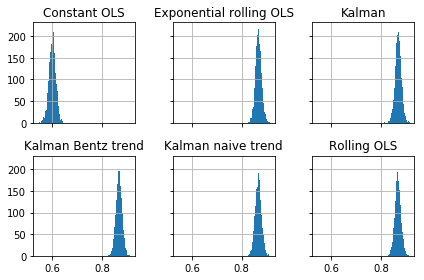

In [387]:
performance_record_wacc.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

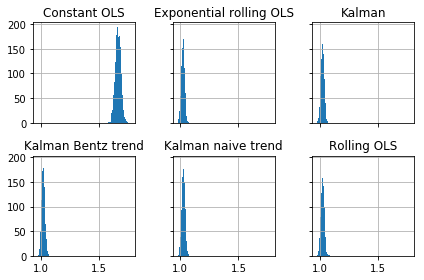

In [388]:
performance_record_mse.hist(layout=(2, 3), bins=50, sharex=True, sharey=True)
plt.tight_layout()

In [389]:
import pickle
with open('20190312-wERR-performance_record.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [1264]:
with open('performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
ls

{'MSE':       Constant OLS    Kalman  Kalman Bentz trend  Kalman naive trend  \
 0         1.642084  0.959128            0.969325            0.934450   
 1         1.652597  0.953329            0.964440            0.928491   
 2         1.672936  0.956445            0.966112            0.932220   
 3         1.673412  0.957570            0.967425            0.932708   
 4         1.673309  0.965016            0.974735            0.940621   
 5         1.683193  0.963870            0.972889            0.940625   
 6         1.654992  0.967241            0.977574            0.942468   
 7         1.658842  0.940273            0.949614            0.916005   
 8         1.660779  0.952864            0.963289            0.928959   
 9         1.661458  0.964175            0.974029            0.939953   
 10        1.666550  0.978255            0.987707            0.952743   
 11        1.682632  0.947483            0.958717            0.923289   
 12        1.645867  0.966099            0.9

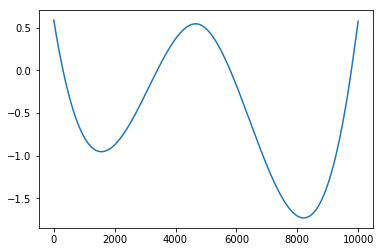

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()